# Transfer learning - Survival prediction
Here we are initializing the survival prediction task by using the pre-trained weights from the "foundation model" and fine tuning on survival prediction. We use for training 70% of the data and 30% for validation. 

This notebook guides you through the use of the clinical transformere API

In [1]:
import os
os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir=/home/shenwanxiang/anaconda3"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import tensorflow as tf
tf.test.is_gpu_available()

tf.config.run_functions_eagerly(True)

tf.__version__
import sys
sys.path.append('../codeocean/environment/clinical_transformer/')



2025-08-12 20:26:37.431714: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-12 20:26:37.495654: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-12 20:26:37.863839: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/shenwanxiang/anaconda3/lib:
2025-08-12 20:26:37.863874: W tensorflow/compiler/xla/stream_exe

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2025-08-12 20:26:38.308968: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-12 20:26:38.321461: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-08-12 20:26:38.338212: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-08-12 20:26:38.338312: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at

In [2]:
from xai.models import Trainer
from xai.models import SurvivalTransformer
from xai.models import OptimizedSurvivalDataGenerator as SurvivalDataGenerator
from xai.losses.survival import cIndex_SigmoidApprox as cindex_loss
from xai.metrics.survival import sigmoid_concordance as cindex_metric

In [3]:
import pandas as pd
from samecode.random import set_seed

## Dataset

In [4]:
data = pd.read_csv('./data/dataset-train.data.csv')
features = data.columns[-44:].tolist()
features

['CANCER',
 'Bcell_general',
 'Memory_Bcell',
 'Naive_Bcell',
 'Plasma_cell',
 'CD4_Tcell',
 'CD8_Tcell',
 'Memory_Tcell',
 'Naive_Tcell',
 'Tcell_general',
 'Cytotoxic_Tcell',
 'Exhausted_Tcell',
 'Immune_checkpoint',
 'Treg',
 'NKcell',
 'Innate_lymphoid_cell',
 'cDC',
 'pDC',
 'Macrophage',
 'Monocyte',
 'Myeloid',
 'Granulocyte',
 'Mast',
 'Erythrocyte',
 'Platelet',
 'Stem',
 'Stroma',
 'Pericyte',
 'Fibroblast',
 'Endothelial',
 'Epithelial',
 'Mesothelial',
 'Adipocyte',
 'Hepatocyte',
 'Pancreatic',
 'Pneumocyte',
 'Apoptosis_pathway',
 'IFNg_pathway',
 'TGFb_pathway',
 'Cytokine',
 'Cell_proliferation',
 'TLS',
 'Genome_integrity',
 'Reference']

## Parameters

In [5]:
max_features_percentile=100
test_size=0.3 # fraction of samples used for validation
repetitions=10 # number replicates (training / validation) random splits to evaluate variability.

mode='survival'
learning_rate=0.0001
epochs=300
verbose=1
seed=0
embedding_size = 128
num_heads = 2
num_layers = 2

## Training

In [6]:
!rm -r ./results/runs/TransferLearningSurvival/

/bin/sh: /home/shenwanxiang/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/sh)
rm: cannot remove './results/runs/TransferLearningSurvival/': No such file or directory


In [7]:
outdir = './results/runs/TransferLearningSurvival/'
set_seed(0)

trainer = Trainer(
    from_pretrained='./results/runs/FoundationModel/fold-0_id-0/model.E001000.h5',
    out_dir = outdir,
    max_features_percentile=max_features_percentile,
    test_size=test_size,
    mode=mode,
    model=SurvivalTransformer, 
    dataloader=SurvivalDataGenerator,
    loss=cindex_loss,
    metrics=[cindex_metric]
)

trainer.setup_data(
    data, 
    discrete_features = [],
    continuous_features = features,
    target=['time', 'event']
)

trainer.setup_model(
    learning_rate=learning_rate,
    embedding_size=embedding_size,
    num_heads=num_heads,
    num_layers=num_layers,
    batch_size_max=True,
    save_best_only=True
)

trainer.fit(repetitions=repetitions, epochs=epochs, verbose=verbose, seed=seed)

/home/shenwanxiang/.local/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO	2025-08-12 20:26:39,965	Setting up working directory: ./results/runs/TransferLearningSurvival/
INFO	2025-08-12 20:26:39,966	Setting up transfer learning directory: ./results/runs/TransferLearningSurvival//model.E001000.h5/
2025-08-12 20:26:39.969257: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-08-12 20:26:39.969403: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-08-12 20:26:39.969465: I tensorflow/compil

Epoch 1/300
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


WARNING	2025-08-12 20:26:41,129	AutoGraph could not transform <function cIndex_SigmoidApprox at 0x7f7b309a7320> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


WARNING	2025-08-12 20:26:41,238	AutoGraph could not transform <function sigmoid_concordance at 0x7f7b2dd437a0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 0s 279ms/step - loss: 0.5073 - sigmoid_concordance: 0.4871 - val_loss: 0.4965 - val_sigmoid_concordance: 0.5353
Epoch 2/300
1/1 [==============================] - 0s 128ms/step - loss: 0.5067 - sigmoid_concordance: 0.4840 - val_loss: 0.4965 - val_sigmoid_concordance: 0.5341
Epoch 3/300
1/1 [==============================] - 0s 132ms/step - loss: 0.4966 - sigmoid_concordance: 0.5120 - val_loss: 0.4965 - val_sigmoid_concordance: 0.5370
Epoch 4/300
1/1 [==============================] - 0s 126ms/step - loss: 0.4953 - sigmoid_concordance: 0.5095 - val_loss: 0.4965 - val_sigmoid_concordance: 0.5471
Epoch 5/300
1/1 [==============================] - 0s 133

INFO	2025-08-12 20:27:22,641	RUN ID: fold-1_id-1
INFO	2025-08-12 20:27:22,641	RUN ID out directory: ./results/runs/TransferLearningSurvival//model.E001000.h5//fold-1_id-1/
INFO	2025-08-12 20:27:22,700	Training samples: 393
INFO	2025-08-12 20:27:22,700	Testing samples: 169
INFO	2025-08-12 20:27:22,703	Number of features at 100th percentile: 44 that are non nans


Epoch 1/300


/home/shenwanxiang/anaconda3/envs/IRnet_env/lib/python3.7/site-packages/tensorflow/python/data/ops/structured_function.py:257: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


1/1 [==============================] - 0s 201ms/step - loss: 0.4964 - sigmoid_concordance: 0.5073 - val_loss: 0.5035 - val_sigmoid_concordance: 0.4821
Epoch 2/300
1/1 [==============================] - 0s 139ms/step - loss: 0.4819 - sigmoid_concordance: 0.5356 - val_loss: 0.5020 - val_sigmoid_concordance: 0.4915
Epoch 3/300
1/1 [==============================] - 0s 139ms/step - loss: 0.5089 - sigmoid_concordance: 0.4845 - val_loss: 0.5003 - val_sigmoid_concordance: 0.5016
Epoch 4/300
1/1 [==============================] - 0s 140ms/step - loss: 0.4998 - sigmoid_concordance: 0.5064 - val_loss: 0.4984 - val_sigmoid_concordance: 0.5134
Epoch 5/300
1/1 [==============================] - 0s 143ms/step - loss: 0.4936 - sigmoid_concordance: 0.5193 - val_loss: 0.4963 - val_sigmoid_concordance: 0.5226
Epoch 6/300
1/1 [==============================] - 0s 141ms/step - loss: 0.4921 - sigmoid_concordance: 0.5259 - val_loss: 0.4944 - val_sigmoid_concordance: 0.5333
Epoch 7/300
1/1 [=================

INFO	2025-08-12 20:28:05,002	RUN ID: fold-2_id-2
INFO	2025-08-12 20:28:05,002	RUN ID out directory: ./results/runs/TransferLearningSurvival//model.E001000.h5//fold-2_id-2/
INFO	2025-08-12 20:28:05,062	Training samples: 393
INFO	2025-08-12 20:28:05,063	Testing samples: 169
INFO	2025-08-12 20:28:05,066	Number of features at 100th percentile: 44 that are non nans


Epoch 1/300


/home/shenwanxiang/anaconda3/envs/IRnet_env/lib/python3.7/site-packages/tensorflow/python/data/ops/structured_function.py:257: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


1/1 [==============================] - 0s 200ms/step - loss: 0.5009 - sigmoid_concordance: 0.4963 - val_loss: 0.4917 - val_sigmoid_concordance: 0.5340
Epoch 2/300
1/1 [==============================] - 0s 138ms/step - loss: 0.4856 - sigmoid_concordance: 0.5313 - val_loss: 0.4902 - val_sigmoid_concordance: 0.5364
Epoch 3/300
1/1 [==============================] - 0s 138ms/step - loss: 0.4890 - sigmoid_concordance: 0.5256 - val_loss: 0.4888 - val_sigmoid_concordance: 0.5407
Epoch 4/300
1/1 [==============================] - 0s 137ms/step - loss: 0.4846 - sigmoid_concordance: 0.5367 - val_loss: 0.4871 - val_sigmoid_concordance: 0.5453
Epoch 5/300
1/1 [==============================] - 0s 139ms/step - loss: 0.4926 - sigmoid_concordance: 0.5168 - val_loss: 0.4854 - val_sigmoid_concordance: 0.5465
Epoch 6/300
1/1 [==============================] - 0s 137ms/step - loss: 0.4954 - sigmoid_concordance: 0.5150 - val_loss: 0.4836 - val_sigmoid_concordance: 0.5512
Epoch 7/300
1/1 [=================

INFO	2025-08-12 20:28:46,782	RUN ID: fold-3_id-3
INFO	2025-08-12 20:28:46,783	RUN ID out directory: ./results/runs/TransferLearningSurvival//model.E001000.h5//fold-3_id-3/
INFO	2025-08-12 20:28:46,843	Training samples: 393
INFO	2025-08-12 20:28:46,843	Testing samples: 169
INFO	2025-08-12 20:28:46,846	Number of features at 100th percentile: 44 that are non nans


Epoch 1/300


/home/shenwanxiang/anaconda3/envs/IRnet_env/lib/python3.7/site-packages/tensorflow/python/data/ops/structured_function.py:257: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


1/1 [==============================] - 0s 200ms/step - loss: 0.5146 - sigmoid_concordance: 0.4646 - val_loss: 0.5080 - val_sigmoid_concordance: 0.4529
Epoch 2/300
1/1 [==============================] - 0s 139ms/step - loss: 0.5081 - sigmoid_concordance: 0.4842 - val_loss: 0.5066 - val_sigmoid_concordance: 0.4571
Epoch 3/300
1/1 [==============================] - 0s 138ms/step - loss: 0.4966 - sigmoid_concordance: 0.5182 - val_loss: 0.5051 - val_sigmoid_concordance: 0.4653
Epoch 4/300
1/1 [==============================] - 0s 139ms/step - loss: 0.4849 - sigmoid_concordance: 0.5356 - val_loss: 0.5036 - val_sigmoid_concordance: 0.4729
Epoch 5/300
1/1 [==============================] - 0s 136ms/step - loss: 0.4857 - sigmoid_concordance: 0.5317 - val_loss: 0.5023 - val_sigmoid_concordance: 0.4819
Epoch 6/300
1/1 [==============================] - 0s 139ms/step - loss: 0.4875 - sigmoid_concordance: 0.5328 - val_loss: 0.5009 - val_sigmoid_concordance: 0.4919
Epoch 7/300
1/1 [=================

INFO	2025-08-12 20:29:29,834	RUN ID: fold-4_id-4
INFO	2025-08-12 20:29:29,835	RUN ID out directory: ./results/runs/TransferLearningSurvival//model.E001000.h5//fold-4_id-4/
INFO	2025-08-12 20:29:29,895	Training samples: 393
INFO	2025-08-12 20:29:29,895	Testing samples: 169
INFO	2025-08-12 20:29:29,898	Number of features at 100th percentile: 44 that are non nans


Epoch 1/300


/home/shenwanxiang/anaconda3/envs/IRnet_env/lib/python3.7/site-packages/tensorflow/python/data/ops/structured_function.py:257: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


1/1 [==============================] - 0s 210ms/step - loss: 0.4837 - sigmoid_concordance: 0.5351 - val_loss: 0.4899 - val_sigmoid_concordance: 0.5831
Epoch 2/300
1/1 [==============================] - 0s 139ms/step - loss: 0.4903 - sigmoid_concordance: 0.5202 - val_loss: 0.4888 - val_sigmoid_concordance: 0.5879
Epoch 3/300
1/1 [==============================] - 0s 141ms/step - loss: 0.5046 - sigmoid_concordance: 0.4931 - val_loss: 0.4875 - val_sigmoid_concordance: 0.5904
Epoch 4/300
1/1 [==============================] - 0s 137ms/step - loss: 0.4965 - sigmoid_concordance: 0.5036 - val_loss: 0.4860 - val_sigmoid_concordance: 0.5951
Epoch 5/300
1/1 [==============================] - 0s 136ms/step - loss: 0.4997 - sigmoid_concordance: 0.4988 - val_loss: 0.4846 - val_sigmoid_concordance: 0.5932
Epoch 6/300
1/1 [==============================] - 0s 138ms/step - loss: 0.4906 - sigmoid_concordance: 0.5237 - val_loss: 0.4834 - val_sigmoid_concordance: 0.5908
Epoch 7/300
1/1 [=================

INFO	2025-08-12 20:30:11,403	RUN ID: fold-5_id-5
INFO	2025-08-12 20:30:11,403	RUN ID out directory: ./results/runs/TransferLearningSurvival//model.E001000.h5//fold-5_id-5/
INFO	2025-08-12 20:30:11,460	Training samples: 393
INFO	2025-08-12 20:30:11,460	Testing samples: 169
INFO	2025-08-12 20:30:11,463	Number of features at 100th percentile: 44 that are non nans


Epoch 1/300


/home/shenwanxiang/anaconda3/envs/IRnet_env/lib/python3.7/site-packages/tensorflow/python/data/ops/structured_function.py:257: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


1/1 [==============================] - 0s 195ms/step - loss: 0.4962 - sigmoid_concordance: 0.5010 - val_loss: 0.4995 - val_sigmoid_concordance: 0.5124
Epoch 2/300
1/1 [==============================] - 0s 130ms/step - loss: 0.4883 - sigmoid_concordance: 0.5371 - val_loss: 0.4992 - val_sigmoid_concordance: 0.5122
Epoch 3/300
1/1 [==============================] - 0s 149ms/step - loss: 0.4972 - sigmoid_concordance: 0.5061 - val_loss: 0.4991 - val_sigmoid_concordance: 0.5124
Epoch 4/300
1/1 [==============================] - 0s 134ms/step - loss: 0.4869 - sigmoid_concordance: 0.5294 - val_loss: 0.4989 - val_sigmoid_concordance: 0.5140
Epoch 5/300
1/1 [==============================] - 0s 138ms/step - loss: 0.4877 - sigmoid_concordance: 0.5382 - val_loss: 0.4986 - val_sigmoid_concordance: 0.5138
Epoch 6/300
1/1 [==============================] - 0s 133ms/step - loss: 0.5008 - sigmoid_concordance: 0.5008 - val_loss: 0.4982 - val_sigmoid_concordance: 0.5143
Epoch 7/300
1/1 [=================

INFO	2025-08-12 20:30:52,650	RUN ID: fold-6_id-6
INFO	2025-08-12 20:30:52,651	RUN ID out directory: ./results/runs/TransferLearningSurvival//model.E001000.h5//fold-6_id-6/
INFO	2025-08-12 20:30:52,707	Training samples: 393
INFO	2025-08-12 20:30:52,707	Testing samples: 169
INFO	2025-08-12 20:30:52,710	Number of features at 100th percentile: 44 that are non nans


Epoch 1/300


/home/shenwanxiang/anaconda3/envs/IRnet_env/lib/python3.7/site-packages/tensorflow/python/data/ops/structured_function.py:257: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


1/1 [==============================] - 0s 200ms/step - loss: 0.4933 - sigmoid_concordance: 0.5141 - val_loss: 0.4903 - val_sigmoid_concordance: 0.5667
Epoch 2/300
1/1 [==============================] - 0s 133ms/step - loss: 0.4921 - sigmoid_concordance: 0.5182 - val_loss: 0.4889 - val_sigmoid_concordance: 0.5735
Epoch 3/300
1/1 [==============================] - 0s 135ms/step - loss: 0.4944 - sigmoid_concordance: 0.5149 - val_loss: 0.4873 - val_sigmoid_concordance: 0.5776
Epoch 4/300
1/1 [==============================] - 0s 132ms/step - loss: 0.4982 - sigmoid_concordance: 0.5046 - val_loss: 0.4860 - val_sigmoid_concordance: 0.5839
Epoch 5/300
1/1 [==============================] - 0s 130ms/step - loss: 0.5005 - sigmoid_concordance: 0.5018 - val_loss: 0.4845 - val_sigmoid_concordance: 0.5862
Epoch 6/300
1/1 [==============================] - 0s 131ms/step - loss: 0.4842 - sigmoid_concordance: 0.5303 - val_loss: 0.4832 - val_sigmoid_concordance: 0.5866
Epoch 7/300
1/1 [=================

INFO	2025-08-12 20:31:34,083	RUN ID: fold-7_id-7
INFO	2025-08-12 20:31:34,083	RUN ID out directory: ./results/runs/TransferLearningSurvival//model.E001000.h5//fold-7_id-7/
INFO	2025-08-12 20:31:34,140	Training samples: 393
INFO	2025-08-12 20:31:34,140	Testing samples: 169
INFO	2025-08-12 20:31:34,143	Number of features at 100th percentile: 44 that are non nans


Epoch 1/300


/home/shenwanxiang/anaconda3/envs/IRnet_env/lib/python3.7/site-packages/tensorflow/python/data/ops/structured_function.py:257: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


1/1 [==============================] - 0s 190ms/step - loss: 0.5139 - sigmoid_concordance: 0.4631 - val_loss: 0.5079 - val_sigmoid_concordance: 0.4515
Epoch 2/300
1/1 [==============================] - 0s 129ms/step - loss: 0.5270 - sigmoid_concordance: 0.4402 - val_loss: 0.5066 - val_sigmoid_concordance: 0.4603
Epoch 3/300
1/1 [==============================] - 0s 149ms/step - loss: 0.4800 - sigmoid_concordance: 0.5523 - val_loss: 0.5052 - val_sigmoid_concordance: 0.4691
Epoch 4/300
1/1 [==============================] - 0s 133ms/step - loss: 0.4982 - sigmoid_concordance: 0.5009 - val_loss: 0.5039 - val_sigmoid_concordance: 0.4753
Epoch 5/300
1/1 [==============================] - 0s 132ms/step - loss: 0.4946 - sigmoid_concordance: 0.5149 - val_loss: 0.5027 - val_sigmoid_concordance: 0.4820
Epoch 6/300
1/1 [==============================] - 0s 139ms/step - loss: 0.5106 - sigmoid_concordance: 0.4705 - val_loss: 0.5015 - val_sigmoid_concordance: 0.4865
Epoch 7/300
1/1 [=================

INFO	2025-08-12 20:32:15,079	RUN ID: fold-8_id-8
INFO	2025-08-12 20:32:15,079	RUN ID out directory: ./results/runs/TransferLearningSurvival//model.E001000.h5//fold-8_id-8/
INFO	2025-08-12 20:32:15,135	Training samples: 393
INFO	2025-08-12 20:32:15,135	Testing samples: 169
INFO	2025-08-12 20:32:15,138	Number of features at 100th percentile: 44 that are non nans


Epoch 1/300


/home/shenwanxiang/anaconda3/envs/IRnet_env/lib/python3.7/site-packages/tensorflow/python/data/ops/structured_function.py:257: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


1/1 [==============================] - 0s 200ms/step - loss: 0.4857 - sigmoid_concordance: 0.5304 - val_loss: 0.4984 - val_sigmoid_concordance: 0.5172
Epoch 2/300
1/1 [==============================] - 0s 138ms/step - loss: 0.4983 - sigmoid_concordance: 0.4954 - val_loss: 0.4975 - val_sigmoid_concordance: 0.5228
Epoch 3/300
1/1 [==============================] - 0s 148ms/step - loss: 0.4853 - sigmoid_concordance: 0.5372 - val_loss: 0.4965 - val_sigmoid_concordance: 0.5259
Epoch 4/300
1/1 [==============================] - 0s 141ms/step - loss: 0.5069 - sigmoid_concordance: 0.4769 - val_loss: 0.4954 - val_sigmoid_concordance: 0.5287
Epoch 5/300
1/1 [==============================] - 0s 137ms/step - loss: 0.5051 - sigmoid_concordance: 0.4909 - val_loss: 0.4943 - val_sigmoid_concordance: 0.5330
Epoch 6/300
1/1 [==============================] - 0s 147ms/step - loss: 0.5023 - sigmoid_concordance: 0.4981 - val_loss: 0.4930 - val_sigmoid_concordance: 0.5363
Epoch 7/300
1/1 [=================

INFO	2025-08-12 20:32:57,372	RUN ID: fold-9_id-9
INFO	2025-08-12 20:32:57,372	RUN ID out directory: ./results/runs/TransferLearningSurvival//model.E001000.h5//fold-9_id-9/
INFO	2025-08-12 20:32:57,429	Training samples: 393
INFO	2025-08-12 20:32:57,429	Testing samples: 169
INFO	2025-08-12 20:32:57,432	Number of features at 100th percentile: 44 that are non nans


Epoch 1/300


/home/shenwanxiang/anaconda3/envs/IRnet_env/lib/python3.7/site-packages/tensorflow/python/data/ops/structured_function.py:257: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


1/1 [==============================] - 0s 190ms/step - loss: 0.4897 - sigmoid_concordance: 0.5248 - val_loss: 0.4950 - val_sigmoid_concordance: 0.5359
Epoch 2/300
1/1 [==============================] - 0s 136ms/step - loss: 0.4922 - sigmoid_concordance: 0.5179 - val_loss: 0.4930 - val_sigmoid_concordance: 0.5479
Epoch 3/300
1/1 [==============================] - 0s 131ms/step - loss: 0.4641 - sigmoid_concordance: 0.5711 - val_loss: 0.4906 - val_sigmoid_concordance: 0.5576
Epoch 4/300
1/1 [==============================] - 0s 131ms/step - loss: 0.4974 - sigmoid_concordance: 0.5030 - val_loss: 0.4880 - val_sigmoid_concordance: 0.5687
Epoch 5/300
1/1 [==============================] - 0s 133ms/step - loss: 0.4923 - sigmoid_concordance: 0.5227 - val_loss: 0.4856 - val_sigmoid_concordance: 0.5753
Epoch 6/300
1/1 [==============================] - 0s 144ms/step - loss: 0.4922 - sigmoid_concordance: 0.5165 - val_loss: 0.4829 - val_sigmoid_concordance: 0.5812
Epoch 7/300
1/1 [=================

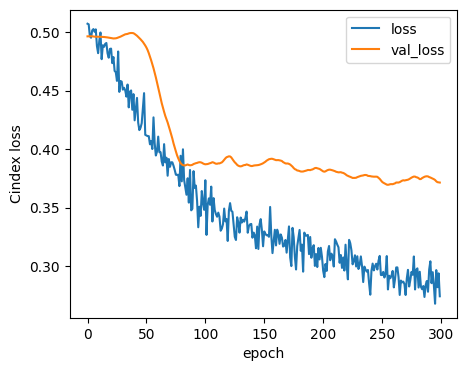

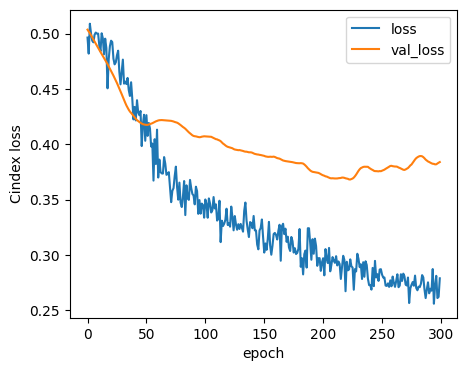

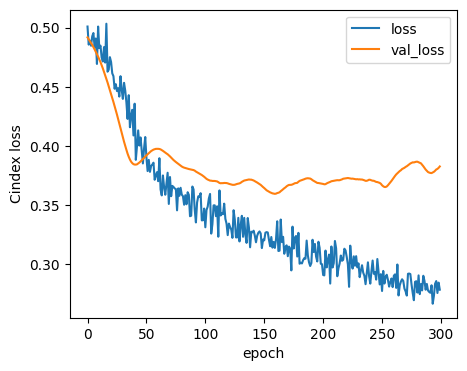

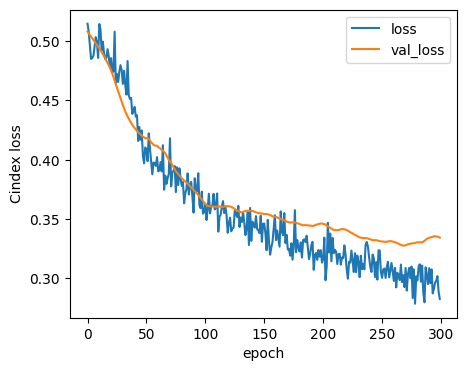

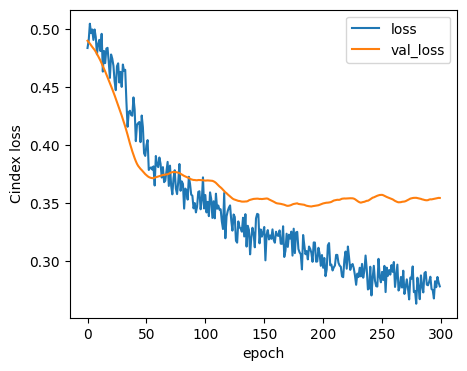

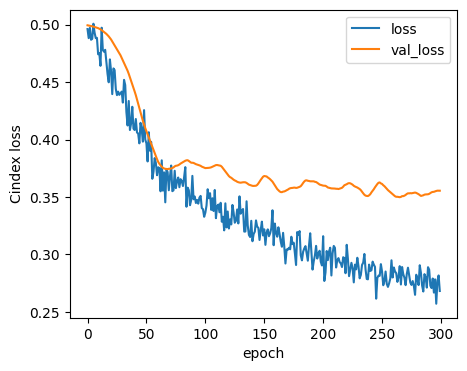

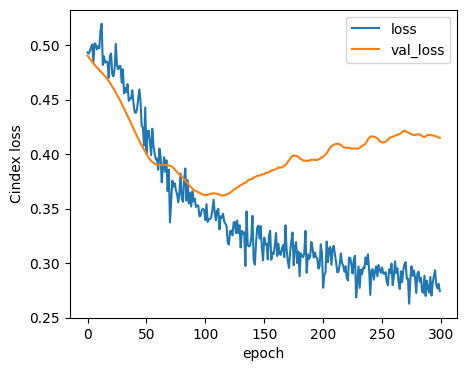

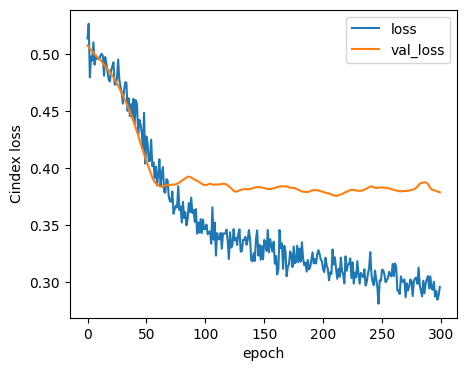

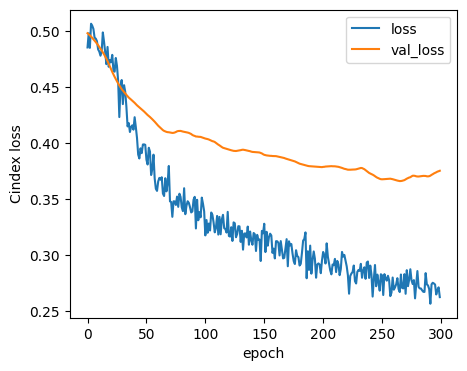

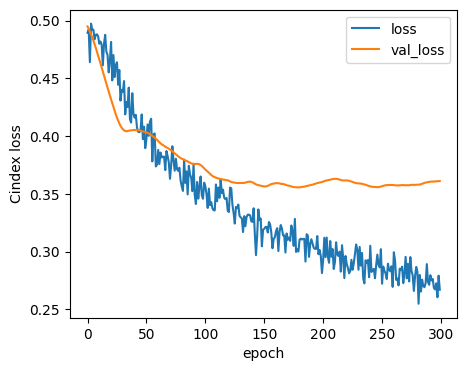

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

for i in range(repetitions):
    dfh = pd.read_csv("./results/runs/TransferLearningSurvival/model.E001000.h5/fold-%s_id-%s/history.csv" % (i,i), index_col=0)
    fig, ax=plt.subplots(figsize=(5,4))
    dfh[['loss', 'val_loss']].plot(ax=ax)
    ax.set_ylabel('Cindex loss')